In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets
from sklearn.model_selection import GridSearchCV

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.75

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
indices = dict((c, i) for i, c in enumerate(callers))

In [8]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [9]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [10]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [11]:
data = [apps.assemble_data(sample, callers, out_dir) for sample in samples]

start = time.time()
X = np.array(sum([data.result()[0] for data in data], []))
Y = np.array(sum([data.result()[1] for data in data], []))

print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 36.4s


In [12]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [ ]:
start = time.time()

n = 12000
def au_prc(ground_truth, predictions):
    try:
        precision, recall, _ = precision_recall_curve(ground_truth, predictions)
        result = auc(precision, recall)
    except ValueError:
        result = 0
    
    return result

au_prc_score = make_scorer(au_prc, greater_is_better=True)

param_grid = [
    {'kernel': ['rbf'],
     'gamma': [1e-3, 1e-4],
     'C': [1, 10, 100, 1000]
    },
    {'kernel': ['linear'],
     'C': [1, 10, 100, 1000]
    }
]

param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': [1e-3, 1e-4, 1e-6, 1e-7, 'auto']
}

clf = GridSearchCV(
#    svm.SVC(), param_grid, scoring='f1', n_jobs=-1, cv=3
#    svm.SVC(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3
#     svm.SVC(), param_grid, scoring=au_prc_score, n_jobs=-1, cv=3
    svm.SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=3
)
clf.fit(transformations.flatten(X), Y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print(clf.best_score_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('tuned parameters in {:.1f}s'.format((time.time() - start)))

In [33]:
start = time.time()

def au_prc(ground_truth, predictions):
    try:
        precision, recall, _ = precision_recall_curve(ground_truth, predictions)
        result = auc(precision, recall)
    except ValueError:
        result = 0
    
    return result

au_prc_score = make_scorer(au_prc, greater_is_better=True)

param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}




clf = GridSearchCV(
#    svm.SVC(), param_grid, scoring='f1', n_jobs=-1, cv=3
#    svm.SVC(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3
#    svm.SVC(), param_grid, scoring=au_prc_score, n_jobs=-1, cv=3
#    svm.SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=3,
    ensemble.GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10),
    param_grid, scoring='accuracy', n_jobs=-1, cv=3,
)
clf.fit(X, Y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print(clf.best_score_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('tuned parameters in {:.1f}s'.format((time.time() - start)))

Best parameters set found on development set:

{'learning_rate': 0.05, 'n_estimators': 1250}
0.8861970170021977

Grid scores on development set:

0.885 (+/-0.002) for {'learning_rate': 0.15, 'n_estimators': 100}
0.886 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 250}
0.885 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 500}
0.884 (+/-0.004) for {'learning_rate': 0.15, 'n_estimators': 750}
0.883 (+/-0.004) for {'learning_rate': 0.15, 'n_estimators': 1000}
0.882 (+/-0.005) for {'learning_rate': 0.15, 'n_estimators': 1250}
0.881 (+/-0.005) for {'learning_rate': 0.15, 'n_estimators': 1500}
0.880 (+/-0.006) for {'learning_rate': 0.15, 'n_estimators': 1750}
0.885 (+/-0.003) for {'learning_rate': 0.1, 'n_estimators': 100}
0.886 (+/-0.003) for {'learning_rate': 0.1, 'n_estimators': 250}
0.886 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 500}
0.886 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 750}
0.885 (+/-0.004) for {'learning_rate': 0.1, 'n_estimators': 10

In [13]:
training_data = [apps.assemble_data(sample, callers, out_dir) for sample in training_samples]

start = time.time()
X_train = np.array(sum([data.result()[0] for data in training_data], []))
Y_train = np.array(sum([data.result()[1] for data in training_data], []))

print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 30.5s


In [16]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)
classifiers = []
for features in [
            #['pizzly', 'starseqr', 'fusioncatcher'],
            ['pizzly', 'starfusion', 'arriba', 'fusioncatcher'],
            callers,
            #['arriba']
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice'],
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice', 'STAR_FUSION_v1.5'],
            #['STARSEQR', 'ARRIBA', 'STAR_FUSION_v1.5']
        ]:
    
    pruned_indices = [indices[f] for f in features]
    
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(X_train[:, pruned_indices]), Y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]

    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(X_train[:, pruned_indices]), Y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(X_train[:, pruned_indices]), Y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]
    
    label = 'RFC{}features'.format(len(features))
    trans = 'noop'
    classifier = ensemble.RandomForestClassifier()
    classifier.fit(getattr(transformations, trans)(X_train[:, pruned_indices]), Y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, trans)]
    
    label = 'GBC{}features'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(X_train[:, pruned_indices]), Y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, trans)]
    
print('fit models in {:.1f}s'.format((time.time() - start)))

fit models in 26.1s


In [14]:
X_train.shape, sum(Y_train)

((55437, 5), 30000)

In [14]:
#testing_data = [apps.assemble_data(sample, callers, out_dir) for sample in testing_samples]

In [58]:
#start = time.time()
#X_test = np.array(sum([data.result()[0] for data in testing_data], []))
#Y_test = np.array(sum([data.result()[1] for data in testing_data], []))

#print('assembled testing data in {:.1f}s'.format((time.time() - start)))

assembled testing data in 15.1s


In [17]:
# TODO make helper function to ensure this file exists
start = time.time()
futures = []
for sample in testing_samples:
    for label, feature_indices, transformation in classifiers:
        futures += [apps.predict(sample, out_dir, label, feature_indices, transformation, callers)]
model_data = pd.concat([f.result() for f in futures])
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 36.1s


In [18]:
model_data.to_hdf(os.path.join(out_dir, 'model_data.hdf'), 'data', mode='w')

In [19]:
model_data

,sample,caller,fusion,probability,prediction
0,LIB-04625wt,polyfuseRFC4features,STAG2--SNAPC2,0.270000,0
1,LIB-04625wt,polyfuseRFC4features,SLC2A12--PARP6,0.138333,0
2,LIB-04625wt,polyfuseRFC4features,ZNF621--TMEM222,1.000000,1
3,LIB-04625wt,polyfuseRFC4features,TALDO1--EGR1,0.930000,1
4,LIB-04625wt,polyfuseRFC4features,TMEM115--PNKD,0.970000,1
...,...,...,...,...,...
941,LIB-04674wt,polyfuseGBC5features,AC004997.1--KRT33B,0.124775,0
942,LIB-04674wt,polyfuseGBC5features,PGC--VPS36,0.949512,1
943,LIB-04674wt,polyfuseGBC5features,NF2--WWTR1,0.942071,1
944,LIB-04674wt,polyfuseGBC5features,LIPM--AL139011.2,0.129698,0


In [98]:
summary = apps.make_summary(out_dir, testing_samples)

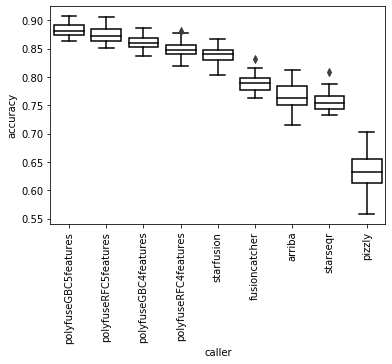

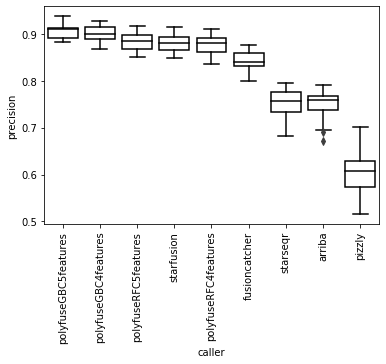

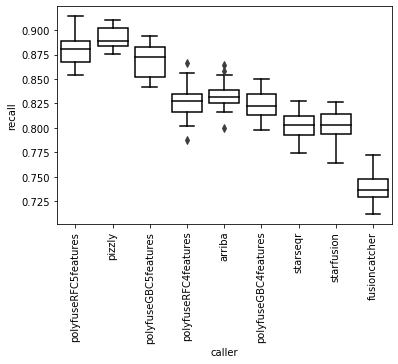

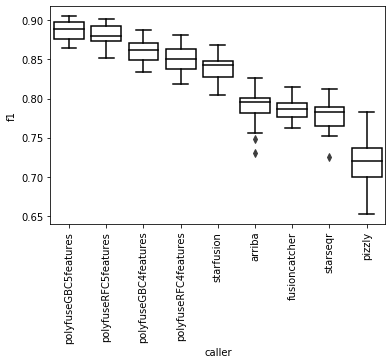

In [99]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [100]:
pd.options.display.max_rows = None
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
polyfuseGBC5features,434.25,45.15,65.75,406.10,0.8685,0.905919,0.883239,0.886742,0.765987
polyfuseRFC5features,439.80,59.30,60.20,391.95,0.8796,0.881474,0.874107,0.880421,0.746226
polyfuseGBC4features,412.40,45.50,87.60,405.75,0.8248,0.900741,0.859860,0.861043,0.721941
polyfuseRFC4features,413.40,57.45,86.60,393.80,0.8268,0.878186,0.848345,0.851609,0.696910
starfusion,401.40,54.45,98.60,396.80,0.8028,0.880617,0.838720,0.839883,0.679671
fusioncatcher,369.50,69.30,130.50,381.95,0.7390,0.842423,0.789125,0.787186,0.583544
arriba,416.65,140.50,83.35,310.75,0.8333,0.748774,0.764727,0.788592,0.526544
starseqr,401.05,130.85,98.95,320.40,0.8021,0.754756,0.758344,0.777520,0.512497
pizzly,445.65,301.65,54.35,149.60,0.8913,0.600050,0.628169,0.716175,0.274850


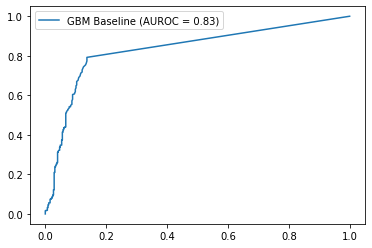

In [106]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

y_true, y_pred, y_prob = apps.score_caller(out_dir, 'LIB-04674wt', 'starfusion').result()

#Y_pred = classifier.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

#plt.figure()
plt.plot(fpr, tpr, label='GBM Baseline (AUROC = {:0.2f})'.format(auroc))
plt.legend()

In [107]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
auprc = auc(recall, precision)

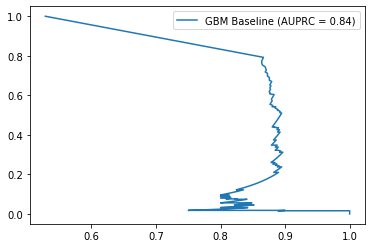

In [108]:
plt.plot(precision, recall, label='GBM Baseline (AUPRC = {:0.2f})'.format(auprc))
plt.legend()
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [19]:
x = np.array([0.59113923])[0]

In [21]:
x

0.59113923

In [90]:
x = [((1, 2, 3), 4, 5)]
for (i, ii, iii), b, c in x:
    print(ii)

2
